In [1]:
using Plots, Distributions, ColorSchemes, Statistics, LinearAlgebra, GeometryBasics, 
        VoronoiCells, Distances, ProgressMeter, Random
default(size=(500,500), titlefontsize=10)
Random.seed!(1234);

In [2]:
function random_points(N::Integer=1)
    
    coordinates = rand(Uniform(),N,2)
    points = [Point2(coordinates[i,:]) for i=1:N]
    return points
end

random_points (generic function with 2 methods)

In [3]:
function rbf(x::Point2;
                weights::Vector{Float64}=[1.0],
                centers::Vector{Point2{Float64}}=[Point2(0.0,0.0)],
                sigma2::Vector{Float64}=[1.0])
    
    @assert length(weights)==length(centers)==length(sigma2)>0 #chequeo consistencia de n>0
    n=length(weights)

    @assert length(x)==length(centers[1]) #chequeo que los centros tengan la dim de x.
    d=length(x)

    
    kernels = [exp(-Euclidean()(x,centers[j])^2/(2*sigma2[j])) for j=1:n]
    return sum(weights.*kernels)
    
end

rbf (generic function with 1 method)

In [5]:
function sample_rbf(N,rbf_func,cota=2.0)
    
    v=Vector{Point2}(undef,N)
    n=0
    
    while(n<N)
        
        x=random_points()[1]
        val  = rbf_func(x)

        u = rand(Uniform())
        
        if val/cota > u
            #accept
            n=n+1
            v[n] = x
        end
    end
    return v
end

sample_rbf (generic function with 2 methods)

## Ground truth

Trabajo en el cuadrado $[0,1]\times [0,1]$. Ponemos 3 centros y 20 puntos de medida

In [6]:
centers = Point2{Float64}[]
push!(centers,Point2(0.6,0.1))
push!(centers,Point2(0.1,0.7))
push!(centers,Point2(0.3,0.4))
push!(centers,Point2(0.8,0.6))

    
mu=centers
sigmas = [.2,.2,.3,.1]
w = [1.0,1.0,1.0,2.0]

4-element Vector{Float64}:
 1.0
 1.0
 1.0
 2.0

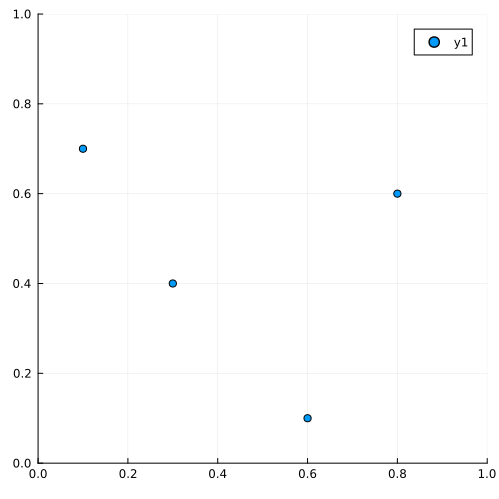

In [7]:
scatter(centers,aspect_ratio=:equal,xlims=(0,1),ylims=(0,1))

#### Ajusto para que sea una densidad de probabilidad

In [8]:
#estimo por montecarlo la integral

N=100000
U = random_points(N)
est = mean(rbf.(U, weights=w,centers=centers,sigma2=sigmas.^2))
scaled_w = w/est
densidad(x::Point2) = rbf(x, weights=scaled_w,centers=centers,sigma2=sigmas.^2)

##chequeo, deberia dar 1
U = random_points(N)
est2 = mean(densidad.(U))

1.0003685851265294

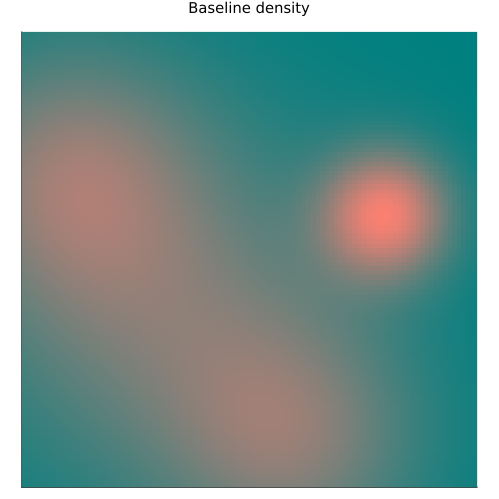

In [12]:
x1=(0:.01:1)
x2=(0:.01:1)

x=[Point2(a,b) for b in x2, a in x1] ##el orden de b y a importa no entendí por qué.

z = densidad.(x)

heatmap(x1,x2,z,
    c=cgrad([:teal, :salmon]),
    axis=false, 
    ticks=false, 
    lims=(0,1),
    colorbar=:none, 
    aspectratio=:equal, 
    legend=:none,    
    title="Baseline density")
savefig("baseline_density.pdf")

In [23]:
surface(x1,x2,z, colorbar=:none, axis=false, grid=false,
    aspectratio=:equal,c=cgrad([:teal, :salmon]), title="Baseline density")
savefig("baseline_density_3d.pdf")

"/home/andres/workspace/julia/transport_problems/Graficas INFORMS/baseline_density_3d.pdf"

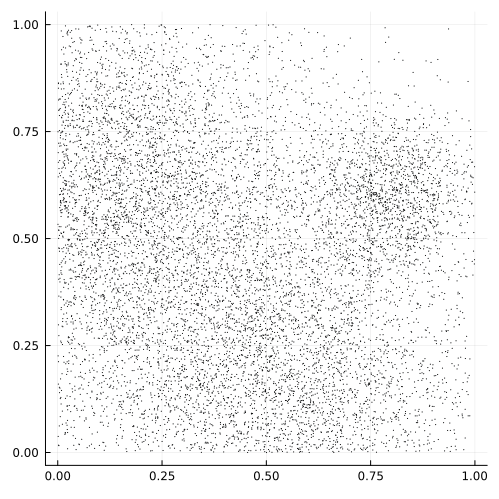

In [24]:
#genero los puntos. La densidad es lambda*g con g rbf la anterior
lambda = 10000.0
Nx = rand(Poisson(lambda))
    
Phi = sample_rbf(Nx,densidad,3)
scatter(Phi,ms=0.1, label=:none)

In [25]:
nu=1/200
consumos = rand(Exponential(1/nu),Nx);

### Genero sitios de medida

In [26]:
m=100

sites=random_points(m)

heatmap(x1,x2,z,
    c=cgrad([:teal, :salmon]),
    axis=false, 
    ticks=false, 
    lims=(0,1),
    colorbar=:none, 
    aspectratio=:equal, 
    legend=:none,
    alpha=0.4,
    title="Measurement points")
scatter!(sites, 
    markersize=3,
    marker=:circle,
    color=:orange,
    markerstrokecolor=:red,
    msw=.5,
    legend=:none, 
)
    
rect = Rectangle(Point2(0.0, 0.0), Point2(1.0, 1.0))
tess = voronoicells(sites, rect);
plot!(tess, color=:teal)
savefig("measurement_points.pdf")

"/home/andres/workspace/julia/transport_problems/Graficas INFORMS/measurement_points.pdf"

### Asocio los puntos

In [27]:
W = [Euclidean()(Phi[i],sites[j]) for i=1:Nx,j=1:m]

attachs = zeros(Int64,Nx)

for i=1:Nx
    _,idx = findmin(W[i,:])
    attachs[i] = idx
end

In [28]:
#Ahora en Phi estan los puntos, en consumos los consumos individuales y 
#en y guardo las medidas posta en los sites

y = [sum(consumos[attachs.==i]) for i=1:m]

scatter(sites, 
    markersize=y/maximum(y)*50,
    marker=:circle, 
    color=:steelblue,
    legend=:none, 
    markeralpha=0.3, 
    aspectratio=:equal, 
    ticks=false, 
    axis=false,
    title="Measured demands",
)

scatter!(sites, 
    markersize=3,
    marker=:circle,
    color=:orange,
    markerstrokecolor=:red,
    msw=.5,
    legend=:none, 
)

savefig("measured_demands.pdf")

"/home/andres/workspace/julia/transport_problems/Graficas INFORMS/measured_demands.pdf"

### Histogram counts

In [15]:
z_histogram = zeros(size(x))
site_counts = zeros(size(x))
        
for j in eachindex(z)
    
    distances = Euclidean().(Ref(x[j]),sites)
    _,idx = findmin(distances)
    site_counts[idx] = site_counts[idx]+1
end

for j in eachindex(z)
    
    distances = Euclidean().(Ref(x[j]),sites)
    _,idx = findmin(distances)
    z_histogram[j] = y[idx]/(site_counts[idx]/length(x))
end

scatter(sites, 
    markersize=3,
    marker=:circle,
    color=:orange,
    markerstrokecolor=:red,
    msw=.5,
    legend=:none, 
)
plot!(tess, color=:teal)

heatmap!(x1,x2,z_histogram,
    c=cgrad([:teal, :salmon]),
    alpha=0.4,
    axis=false, 
    ticks=false, 
    colorbar=:none, title="Histogram counts")

savefig("histogram_counts.pdf")

"/home/andres/workspace/julia/transport_problems/Graficas INFORMS/histogram_counts.pdf"

# Initial condition

In [16]:
using Clustering
sites_matrix = zeros(2,m)
for j=1:m
    sites_matrix[:,j] =[sites[j].data[1],sites[j].data[2]]
end

n=4
km = kmeans(sites_matrix, n, weights=y)
mu0 = [Point2(km.centers[:,i]) for i=1:n]

sigma0 = zeros(n)
for i=1:n
    
    sigma0[i] = sqrt.(mean(km.costs[km.assignments.==i]))
end

### Initial weights

In [17]:
function average_over_voronoi(f::Function, u::Vector{Point2{Float64}}, sites::Vector{Point2{Float64}})

    N=length(u)
    F = zeros(length(sites))
    for k=1:N
        _,idx = findmin(Euclidean().(sites,Ref(u[k])))
        F[idx]+=f(u[k])
    end

    integrals = 1/N * F
    
end


average_over_voronoi (generic function with 1 method)

In [18]:
function update_w(mu,sigma2,y,sites,u,area=1.0)

    A=zeros(length(sites),length(mu))

    for j=1:length(mu)
        A[:,j] = average_over_voronoi(x->rbf(x;weights=[1.0],centers=[mu[j]],sigma2=[sigma2[j]]), u, sites)*area
    end
    return A\y
end

update_w (generic function with 2 methods)

In [19]:
U = random_points(100000)

w0 = update_w(mu0, sigma0.^2, y, sites, U)

4-element Vector{Float64}:
 2.603961344779808e6
 2.1570664660584903e6
 1.4338972683881207e6
 2.326979811575441e6

In [20]:
z0 = rbf.(x,weights=w0,centers=mu0,sigma2=sigma0.^2)

heatmap(x1,x2,z0,
    c=cgrad([:teal, :salmon]),
    axis=false, 
    ticks=false, 
    lims=(0,1),
    colorbar=:none, 
    aspectratio=:equal, 
    legend=:none,    
    title="Initial density estimation")

savefig("initial_condition.pdf")

"/home/andres/workspace/julia/transport_problems/Graficas INFORMS/initial_condition.pdf"

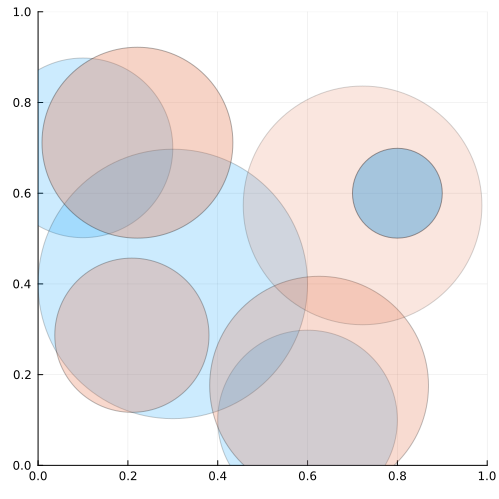

In [21]:
scatter(mu, ms = 500*sigmas, lims=(0,1), alpha=w/sum(w), legend=:none)
scatter!(mu0, ms=500*sigma0, alpha=w0/sum(w0))

## RBF y mean square error

In [22]:
west = w0/sum(y)
muest = mu0
sigma2est = sigma0.^2

#renormalizo y para el ajuste y después deshago
y_norm = y/sum(y);

In [23]:
function compute_gradient(w::Vector{Float64},mu::Vector{Point2{Float64}},sigma2::Vector{Float64},
                          y::Vector{Float64}, sites::Vector{Point2{Float64}}, u::Vector{Point2{Float64}}, 
                          area::Float64=1.0)

    yact = average_over_voronoi(x->rbf(x,weights=w,centers=mu,sigma2=sigma2), u, sites)*area;
    residuals = (yact - y)
    loss = sum(residuals.^2)
    
    k=length(w) #no. de nucleos
    
    dw = zeros(k)
    dmu1 = zeros(k)
    dmu2 = zeros(k)
    dsigma = zeros(k)
    
    for i=1:k
        dw[i] = residuals'*average_over_voronoi(x->rbf(x,weights=[1.0],centers=[mu[i]],sigma2=[sigma2[i]]), u, sites)*area;
        dmu1[i] = residuals'*average_over_voronoi(x->(x[1]-mu[i][1])/(2*sigma2[i])*rbf(x,weights=[w[i]],centers=[mu[i]],sigma2=[sigma2[i]]), u, sites)*area;
        dmu2[i] = residuals'*average_over_voronoi(x->(x[2]-mu[i][2])/(2*sigma2[i])*rbf(x,weights=[w[i]],centers=[mu[i]],sigma2=[sigma2[i]]), u, sites)*area;
        dsigma[i] = residuals'*average_over_voronoi(x->sum((x-mu[i]).^2)/(2*sigma2[i]^2)*rbf(x,weights=[w[i]],centers=[mu[i]],sigma2=[sigma2[i]]), u, sites)*area;
    end

    dmu = [Point2(dmu1[i],dmu2[i]) for i=1:k]
    return dw,dmu,dsigma,loss, residuals
end


compute_gradient (generic function with 2 methods)

In [24]:
N=10000

niter=1000
L=zeros(niter)

step_size = 0.2
@showprogress for iter=1:niter

    u = random_points(N)

    dw,dmu,dsigma,loss,residuals = compute_gradient(west,muest,sigma2est,y_norm,sites,u)

    muest = muest - step_size*dmu
    
    sigma2est = sigma2est - step_size*dsigma
    west = update_w(muest,sigma2est,y_norm,sites,u)
    L[iter] = loss
end

Progress: 100%|█████████████████████████████████████████| Time: 0:02:20


In [25]:
plot(sqrt.(L/length(y)).*sum(y), title="RMSE Loss", xlabel="Iterations", lw=2, color=:teal)
savefig("rmse_loss.pdf")

"/home/andres/workspace/julia/transport_problems/Graficas INFORMS/rmse_loss.pdf"

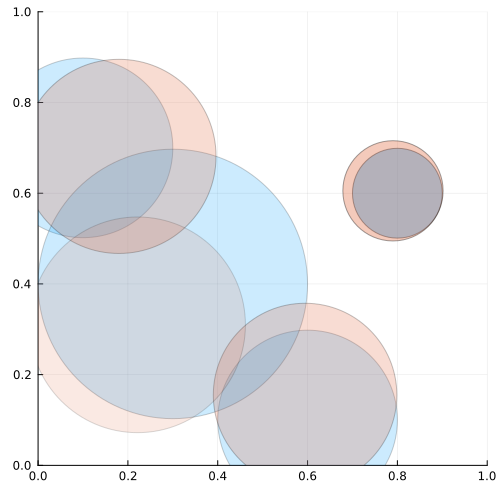

In [26]:
scatter(mu, ms = 500*sigmas, lims=(0,1), alpha=w/sum(w), legend=:none)
scatter!(muest, ms=500*sqrt.(sigma2est), alpha=west/sum(west))

In [27]:
zest = rbf.(x,weights=west*sum(y),centers=muest,sigma2=sigma2est)

plot(
    heatmap(x1,x2,lambda/nu*z,
        c=cgrad([:teal, :salmon]),
        axis=false, 
        ticks=false, 
        lims=(0,1),
        colorbar=:none, 
        aspectratio=:equal, 
        legend=:none,    
        title="Original density")
    , 
    heatmap(x1,x2,zest,
        c=cgrad([:teal, :salmon]),
        axis=false, 
        ticks=false, 
        lims=(0,1),
        colorbar=:none, 
        aspectratio=:equal, 
        legend=:none,    
        title="Reconstructed density"),
layout = (1, 2), size=(1000,500))
savefig("least_squares_result.pdf")

"/home/andres/workspace/julia/transport_problems/Graficas INFORMS/least_squares_result.pdf"

## Maximum likelihood estimation

In [28]:
function compute_ll(lambda_act::Vector{Float64},nuact::Float64, y::Vector{Float64}, n::Vector{Float64})

    llm = zeros(size(n))
        
    for i in eachindex(llm)
       
        llm[i] = -lambda_act[i] + n[i]*log(lambda_act[i])+n[i]*log(nuest)+(n[i]-1)*log(y[i])-nuest*y[i]-sum(log.(1:n[i]))-sum(log.(1:(n[i]-1)))
        
    end
    return sum(llm)
end


compute_ll (generic function with 1 method)

In [29]:
function compute_gradient_ll(w::Vector{Float64},mu::Vector{Point2{Float64}},sigma2::Vector{Float64}, nuact::Float64,
                          y::Vector{Float64}, n::Vector{Float64}, sites::Vector{Point2{Float64}}, u::Vector{Point2{Float64}}, 
                          area::Float64=1.0)

    lambda_act = average_over_voronoi(x->rbf(x,weights=w,centers=mu,sigma2=sigma2), u, sites)*area;
    residuals = (n./lambda_act .- 1)
    loss = compute_ll(lambda_act,nuact,y,n)
    
    k=length(w) #no. de nucleos
    
    dw = zeros(k)
    dmu1 = zeros(k)
    dmu2 = zeros(k)
    dsigma = zeros(k)
    
    for i=1:k
        dw[i] = residuals'*average_over_voronoi(x->rbf(x,weights=[1.0],centers=[mu[i]],sigma2=[sigma2[i]]), u, sites)*area;
        dmu1[i] = residuals'*average_over_voronoi(x->(x[1]-mu[i][1])/(2*sigma2[i])*rbf(x,weights=[w[i]],centers=[mu[i]],sigma2=[sigma2[i]]), u, sites)*area;
        dmu2[i] = residuals'*average_over_voronoi(x->(x[2]-mu[i][2])/(2*sigma2[i])*rbf(x,weights=[w[i]],centers=[mu[i]],sigma2=[sigma2[i]]), u, sites)*area;
        dsigma[i] = residuals'*average_over_voronoi(x->sum((x-mu[i]).^2)/(2*sigma2[i]^2)*rbf(x,weights=[w[i]],centers=[mu[i]],sigma2=[sigma2[i]]), u, sites)*area;
    end

    dmu = [Point2(dmu1[i],dmu2[i]) for i=1:k]
    return dw,dmu,dsigma,loss, residuals
end


compute_gradient_ll (generic function with 2 methods)

In [39]:
nu0 = 1/100
nuest=nu0

west = w0*nu0
muest = mu0
sigma2est = sigma0.^2
#west = west*sum(y)*nu0
west

4-element Vector{Float64}:
 26039.61344779808
 21570.664660584906
 14338.972683881208
 23269.798115754413

In [40]:
N=10000

niter=500
L=zeros(niter)

step_size = 0.2
lambda_act=zeros(length(sites))
    u = random_points(N)
@showprogress for iter=1:niter

    
    u = random_points(N)
    lambda_act = average_over_voronoi(x->rbf(x,weights=west,centers=muest,sigma2=sigma2est), u, sites);

    n = sqrt.(lambda_act.*nuest.*y)

    nuest = sum(n)/sum(y)

    dw,dmu,dsigma,loss,residuals = compute_gradient_ll(west,muest,sigma2est,nuest,y,n,sites,u)

    muest = muest + step_size/sum(west)*dmu
    #println(dmu)
    sigma2est = sigma2est + step_size/sum(west)*dsigma
    #println(dsigma)
    west = west + 20*step_size*dw
    #println(dw)
    L[iter] = loss
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


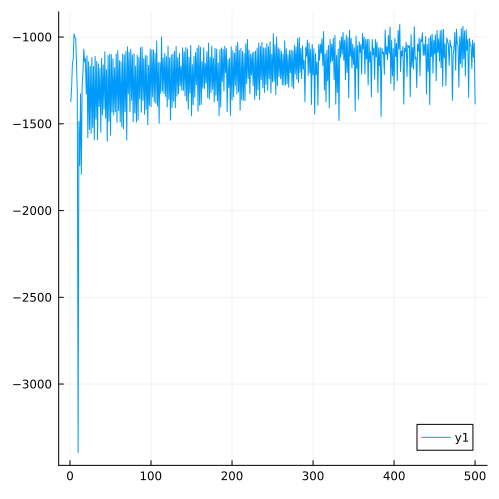

In [41]:
plot(L)

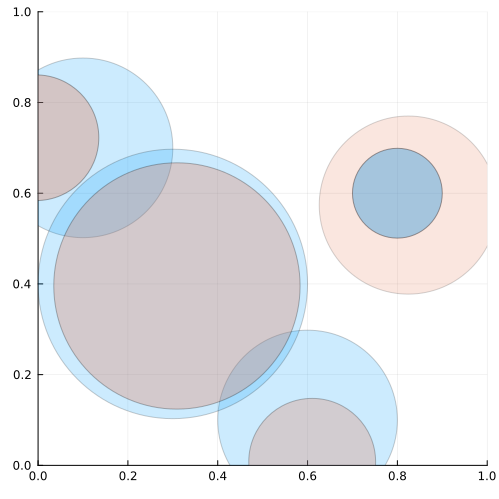

In [42]:
scatter(mu, ms = 500*sigmas, lims=(0,1), alpha=w/sum(w), legend=:none)
scatter!(muest, ms=500*sqrt.(sigma2est), alpha=west/sum(west))

In [43]:
muest

4-element Vector{Point2{Float64}}:
 [-0.004729924323969241, 0.7222961954804467]
 [0.6102991920888717, 0.007802413911487192]
 [0.8242625149321309, 0.573841723262055]
 [0.3091708160235197, 0.3955231584623375]

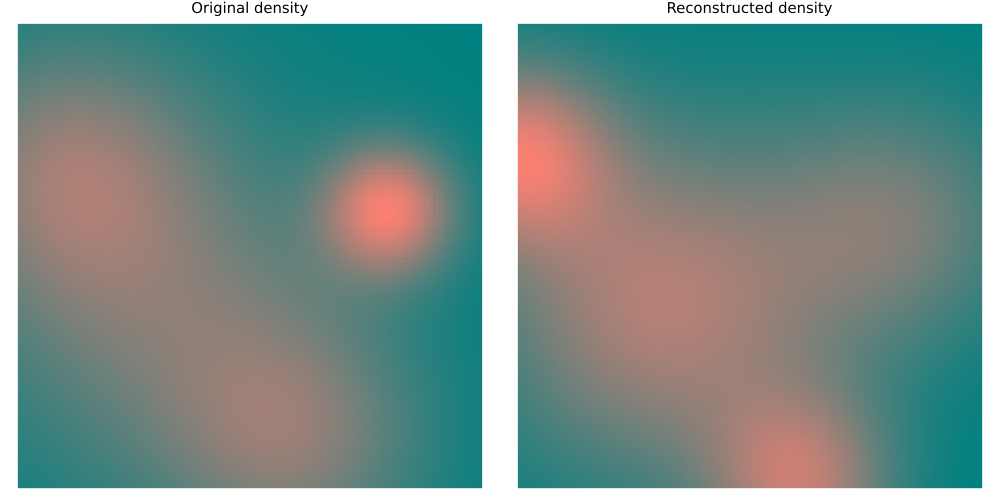

In [44]:
zest = rbf.(x,weights=west,centers=muest,sigma2=sigma2est)

plot(
    heatmap(x1,x2,lambda/nu*z,
        c=cgrad([:teal, :salmon]),
        axis=false, 
        ticks=false, 
        lims=(0,1),
        colorbar=:none, 
        aspectratio=:equal, 
        legend=:none,    
        title="Original density")
    , 
    heatmap(x1,x2,zest,
        c=cgrad([:teal, :salmon]),
        axis=false, 
        ticks=false, 
        lims=(0,1),
        colorbar=:none, 
        aspectratio=:equal, 
        legend=:none,    
        title="Reconstructed density"),
layout = (1, 2), size=(1000,500))

In [36]:
sum(west)

85218.25934361067